# Códigos utilizados no trabalho final

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# base com resultados de fragmentação e gastos de campanha entre 2004 e 2016.
df = pd.read_csv('nep_votos_gastos_magnitude.csv', sep=';', encoding='latin1')
df = df[(df.ano_eleicao != 2008) & (df.codigo_municipio != 83917)]

# separando resultados de 2016 para aplicar modelo validado
df_2016 = df[df.ano_eleicao == 2016]
df = df[df.ano_eleicao != 2016]
df = df[df.magnitude == 9]

## Boxplot das variáveis de interesse

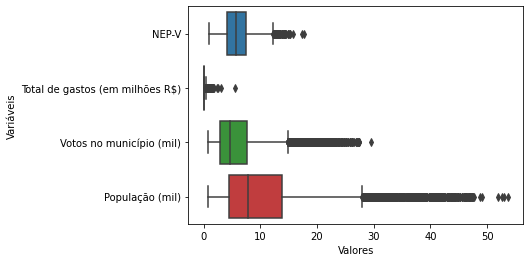

In [2]:
df_boxplot = df.copy()
df_boxplot['total_despesa_milhao'] = df_boxplot.total_despesa / 1000000
df_boxplot['pop_mil'] = df_boxplot['pop'] / 1000
df_boxplot['total_votos_mun_mil'] = df_boxplot.total_votos_mun / 1000
df_boxplot = df_boxplot[['nep_votos', 'total_despesa_milhao', 'total_votos_mun_mil', 'pop_mil']]
df_boxplot = df_boxplot.rename(columns={
    'nep_votos':'NEP-V',
    'total_despesa_milhao':'Total de gastos (em milhões R$)',
    'total_votos_mun_mil':'Votos no município (mil)',
    'pop_mil':'População (mil)'
})

_ = sns.boxplot(data=df_boxplot, orient='h')
plt.ylabel("Variáveis")
plt.xlabel("Valores")
plt.show()

## Pre processamento

In [3]:
# definição do target = numero efetivo de partidos em votos
y = df.nep_votos

# one hot encoding para os estados
uf = df[['uf']]
uf = OneHotEncoder().fit_transform(uf)

# retirando colunas
X = df.loc[:, ~df.columns.isin([
    'nep_votos', 'uf', 'codigo_municipio', 
    'codigo_ibge', 'sigla_uf', 'nome_municipio',
    'ano_eleicao'
    ])]

# combinando features em uma matriz esparsa
X = hstack([X, uf])

# divisão entre as bases de treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

# imputando a mediana dos valores para substituir observações nulas entre as features de treino
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_val = imputer.fit_transform(X_val)

# padronização das features de treino
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X_train)

<6107x31 sparse matrix of type '<class 'numpy.float64'>'
	with 30528 stored elements in Compressed Sparse Row format>

## Random Forest - parameter tuning

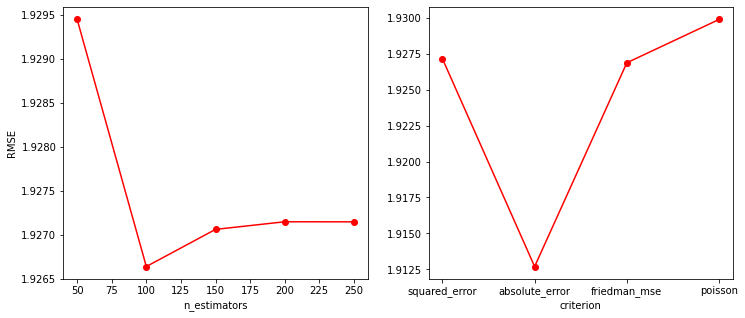

In [4]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)

# verificando melhor parâmetro para n_estimator
estimators = np.arange(50, 300, 50)
rmse_rf_estimators = []
for i in estimators:
    model_rf.set_params(n_estimators=i)
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_val)
    rmse_rf_estimators.append(mean_squared_error(y_val, pred_rf, squared=False))



# verificando melhor parâmetro para criterion
crit = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
rmse_rf = []
for i in crit:
    model_rf.set_params(criterion=i)
    model_rf.fit(X_train, y_train)
    pred_rf = model_rf.predict(X_val)
    rmse_rf.append(mean_squared_error(y_val, pred_rf, squared=False))

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
_ = plt.plot(estimators, rmse_rf_estimators, '-ro')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.subplot(1, 2, 2)
_ = plt.plot(crit, rmse_rf, '-ro')
plt.xlabel("criterion")
plt.show()

In [5]:
model_rf.set_params(n_estimators=60, criterion='absolute_error')
pred_rf = model_rf.predict(X_val)

## XGBoost - parameter tuning

In [6]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train, verbose=False)
pred_xgb = model_xgb.predict(X_val)

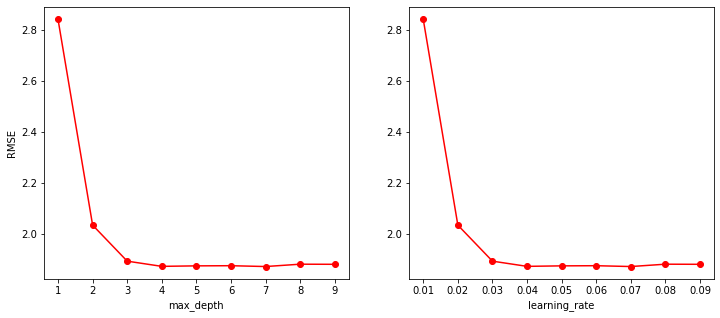

In [7]:
# verificando melhor parâmetro para max_depth
max_depth = np.arange(1, 10, 1)
rmse_xgb = []
for i in max_depth:
    model_xgb.set_params(max_depth=i)
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_val)
    rmse_xgb.append(mean_squared_error(y_val, pred_xgb, squared=False))

learning_rate = np.arange(0.01, 0.1, 0.01)
rmse_xgb = []
for i in learning_rate :
    model_xgb.set_params(learning_rate =i)
    model_xgb.fit(X_train, y_train)
    pred_xgb = model_xgb.predict(X_val)
    rmse_xgb.append(mean_squared_error(y_val, pred_xgb, squared=False))

plt.figure(figsize=(12,5))
_ = plt.subplot(1, 2, 1)
_ = plt.plot(max_depth, rmse_xgb, '-ro')
_ = plt.xlabel("max_depth")
_ = plt.ylabel("RMSE")
_ = plt.subplot(1, 2, 2)
_ = plt.plot(learning_rate , rmse_xgb, '-ro')
_ = plt.xlabel("learning_rate")

In [8]:
model_xgb.set_params(max_depth=1, learning_rate=0.04)
pred_xgb = model_xgb.predict(X_val)
print(f"RMSE:{mean_squared_error(pred_xgb, y_val, squared=False)}")

RMSE:1.881867768970546


## Modelo final aplicado aos dados de 2016: versão com e sem a inclusão do total de gastos de campanha como feature

In [9]:
y = df_2016.nep_votos

# one hot encoding para os estados
uf = df_2016[['uf']]
uf = OneHotEncoder().fit_transform(uf)

# retirando colunas
X = df_2016.loc[:, ~df_2016.columns.isin([
    'nep_votos', 'uf', 'codigo_municipio', 
    'codigo_ibge', 'sigla_uf', 'nome_municipio',
    'ano_eleicao'
    ])]

# combinando features em uma matriz esparsa
X = hstack([X, uf])

# imputando a mediana dos valores para substituir observações nulas entre as features de treino
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# padronização das features de treino
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X)

model_xgb = XGBRegressor(max_depth=3, learning_rate=0.04)

model_xgb.fit(X, y, verbose=False)

pred_xgb = model_xgb.predict(X)


y_pred = model_xgb.predict(X)
print(f"RMSE:{mean_squared_error(y_pred, y, squared=False)}")

RMSE:2.3194694960522013


In [10]:
y = df_2016.nep_votos

# one hot encoding para os estados
uf = df_2016[['uf']]
uf = OneHotEncoder().fit_transform(uf)

# retirando colunas
X = df_2016.loc[:, ~df_2016.columns.isin([
    'nep_votos', 'uf', 'codigo_municipio', 
    'codigo_ibge', 'sigla_uf', 'nome_municipio',
    'ano_eleicao', 'total_despesa'
    ])]

# combinando features em uma matriz esparsa
X = hstack([X, uf])

# imputando a mediana dos valores para substituir observações nulas entre as features de treino
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# padronização das features de treino
scaler = StandardScaler(with_mean=False)
scaler.fit_transform(X)

model_xgb = XGBRegressor(max_depth=3, learning_rate=0.04)

model_xgb.fit(X, y, verbose=False)


y_pred = model_xgb.predict(X)
print(f"RMSE:{mean_squared_error(y_pred, y, squared=False)}")

RMSE:2.3564943065816735
